<a href="https://colab.research.google.com/github/Harishh247/DSA0216-CV/blob/main/cv_activity_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Click CAPTURE and show TWO markers (one left, one right).


<IPython.core.display.Javascript object>

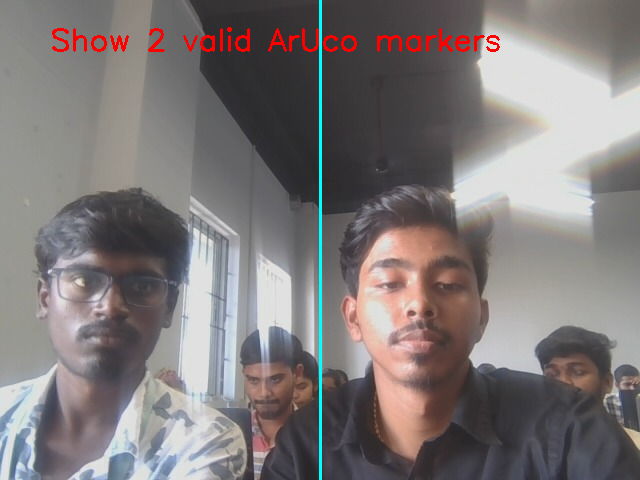

Detected IDs: None


In [ ]:
# ==========================================
# FULLY CORRECTED AR MARKER CARD GAME (COLAB)
# ==========================================

!pip install opencv-contrib-python

import cv2
import cv2.aruco as aruco
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import Javascript, display
from google.colab.output import eval_js
import base64

# -------- Webcam Capture Function --------
def capture_image():
    js = Javascript('''
        async function capture() {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);

            stream.getTracks().forEach(track => track.stop());
            div.remove();

            return canvas.toDataURL('image/jpeg');
        }
    ''')
    display(js)
    data = eval_js('capture()')
    binary = base64.b64decode(data.split(',')[1])
    return cv2.imdecode(np.frombuffer(binary, np.uint8), cv2.IMREAD_COLOR)

# -------- Card Stats --------
cards = {
    0: {"name": "Warrior", "attack": 10, "hp": 50},
    1: {"name": "Mage", "attack": 15, "hp": 40},
    2: {"name": "Tank", "attack": 5, "hp": 80}
}

# -------- ArUco Setup (Improved) --------
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)

parameters = aruco.DetectorParameters()
parameters.adaptiveThreshWinSizeMin = 3
parameters.adaptiveThreshWinSizeMax = 23
parameters.adaptiveThreshWinSizeStep = 10
parameters.minMarkerPerimeterRate = 0.02

detector = aruco.ArucoDetector(aruco_dict, parameters)

print("Click CAPTURE and show TWO markers (one left, one right).")

# Capture Frame
frame = capture_image()

h, w, _ = frame.shape

# Improve lighting robustness
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.equalizeHist(gray)

# Detect markers
corners, ids, rejected = detector.detectMarkers(gray)

player1_card = None
player2_card = None

# Draw center dividing line
cv2.line(frame, (w//2, 0), (w//2, h), (255,255,0), 2)

if ids is not None:
    aruco.drawDetectedMarkers(frame, corners, ids)

    for i in range(len(ids)):
        marker_id = int(ids[i][0])

        if marker_id in cards:
            c = corners[i][0]
            center_x = int(np.mean(c[:, 0]))
            center_y = int(np.mean(c[:, 1]))

            # Draw center point
            cv2.circle(frame, (center_x, center_y), 6, (0,255,255), -1)

            if center_x < w // 2:
                player1_card = marker_id
                cv2.putText(frame,
                            f"P1: {cards[marker_id]['name']}",
                            (10, 40),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            1, (0,255,0), 2)
            else:
                player2_card = marker_id
                cv2.putText(frame,
                            f"P2: {cards[marker_id]['name']}",
                            (w//2 + 10, 40),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            1, (0,0,255), 2)

# -------- Game Logic --------
if player1_card is not None and player2_card is not None:

    p1 = cards[player1_card].copy()
    p2 = cards[player2_card].copy()

    # Attack exchange
    p2["hp"] -= p1["attack"]
    p1["hp"] -= p2["attack"]

    # Display stats
    cv2.putText(frame,
                f"P1 HP: {p1['hp']}",
                (10, h-60),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.9, (0,255,0), 2)

    cv2.putText(frame,
                f"P2 HP: {p2['hp']}",
                (w//2 + 10, h-60),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.9, (0,0,255), 2)

    if p1["hp"] > p2["hp"]:
        winner = "PLAYER 1 WINS!"
    elif p2["hp"] > p1["hp"]:
        winner = "PLAYER 2 WINS!"
    else:
        winner = "DRAW!"

    cv2.putText(frame,
                winner,
                (w//3, h-20),
                cv2.FONT_HERSHEY_SIMPLEX,
                1.2, (255,0,0), 3)

else:
    cv2.putText(frame,
                "Show 2 valid ArUco markers",
                (50, 50),
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0,0,255), 2)

cv2_imshow(frame)

print("Detected IDs:", ids)
